# Link between manifold and Dhat plots

In [1]:
import os

#add the root directory
os.chdir('../')

In [30]:
from tools import *
from utils import *
import matplotlib.lines as mlines
from matplotlib.gridspec import GridSpec
import matplotlib.cm as cm
from matplotlib.ticker import ScalarFormatter
from matplotlib.lines import Line2D
from scipy.signal import find_peaks
from PCAfold.preprocess import center_scale
import matplotlib.ticker as mticker
import h5py
logging.disable(logging.CRITICAL)

In [3]:
data_state_space, data_state_space_source, data_mf, data_T, state_space_names = load_DNS_data()

In [4]:
PV_heuristic, PV_heuristic_source, _ = load_PV(False, data_state_space, data_state_space_source, state_space_names)

In [5]:
PV_optimized, PV_optimized_source, _ = load_PV(True, data_state_space, data_state_space_source, state_space_names,
                                               filename_optimized_PV="Xu-AE-opt_RMSprop-epo_100000-lr_0.025-date_28Jan2025-hour_17h43_Tr35a_s3")

In [6]:
species_to_inspect = "HO2"
data_HO2 = load_array(species_to_inspect, "data-files/", 10)

species_to_inspect = "NO"
data_NO = load_array(species_to_inspect, "data-files/", 10)

In [7]:
path_variance = "data-files/costs/"
name_optimized = "variance_Tr35a_s3-bw_-6_2_100.npy"
name_heuristic = "variance_Xu-bw_-6_2_100-dataset_low.npy"

name_optimized_fl = "variance_Tr35a_s3-bw_-6_2_100-dataset_flamelet.npy"
name_heuristic_fl = "variance_Xu-bw_-6_2_100-dataset_flamelet.npy"

name_optimized_0D = "variance_Tr0D-2q_s0-bw_-6_2_100-dataset_autoignition.npy"
name_heuristic_0D = "variance_Xu-bw_-6_2_100-dataset_autoignition.npy"

penalty_function = 'log-sigma-over-peak'
power = 4
vertical_shift = 1

keys = ['H2O2', 'H2O', 'H2', 'HO2', 'N2O', 'NO2', 'NO', 'O2', 'OH', 'T', 'PV1']

variance_optimized = np.load(f"{path_variance}{name_optimized}", allow_pickle=True).item()
variance_heuristic = np.load(f"{path_variance}{name_heuristic}", allow_pickle=True).item()

(derivative_optimized, bandwidth_values_optimized, max_derivative_optimized) = normalized_variance_derivative(variance_optimized)
(derivative_heuristic, bandwidth_values_heuristic, max_derivative_heuristic) = normalized_variance_derivative(variance_heuristic)

costsOptimized = cost_function_normalized_variance_derivative(variance_optimized,
                                                            penalty_function=penalty_function,
                                                            power=power,
                                                            vertical_shift=vertical_shift,
                                                            norm=None)
costsHeuristic = cost_function_normalized_variance_derivative(variance_heuristic,
                                                            penalty_function=penalty_function,
                                                            power=power,
                                                            vertical_shift=vertical_shift,
                                                            norm=None)

C:\Windows\Temp\ipykernel_8016\2512096569.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  greys = cm.get_cmap('Greys')


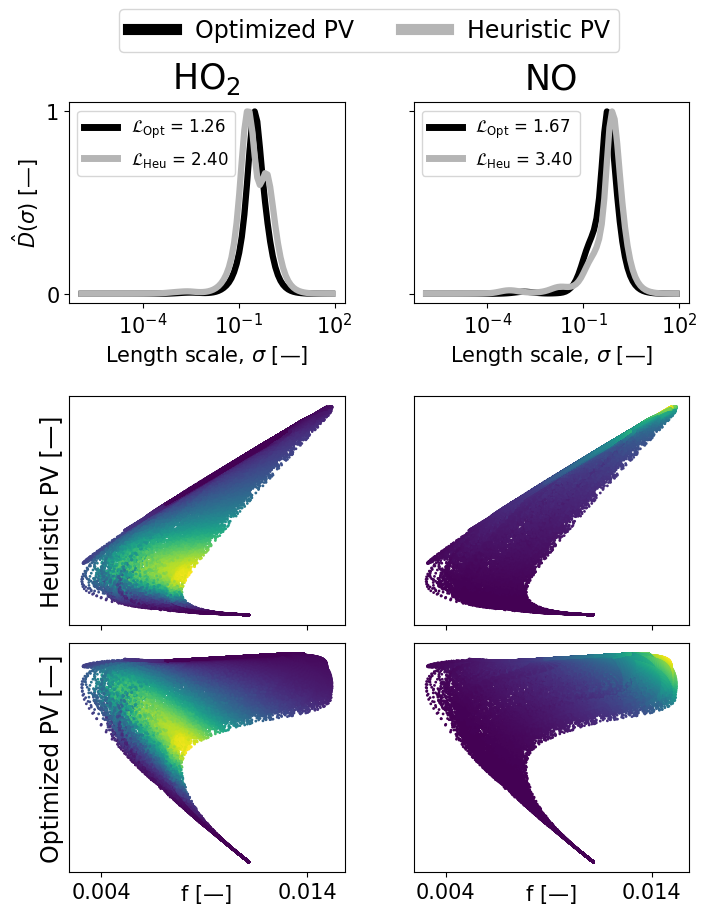

In [9]:
rows, cols = 3,2

selected_keys = ["HO2", "NO"]

save = True
pathSave = "C:/Users/admin/Documents/Parente/Figures/2024-PV-optimization/Paper/Results/Comparison Xu vs optimized/Manifold and Dhat/"
name = "Manifold and Dhat - DNS - HO2 and NO - v2.png"

fig = plt.figure(figsize=(8, 10))
gs = GridSpec(4, 2, width_ratios=[1, 1], height_ratios=[1.4, 0.4, 1.6, 1.6], wspace=0.25, hspace=0.1)

greys = cm.get_cmap('Greys')

for i, key in enumerate(selected_keys):

    ax = fig.add_subplot(gs[0, i])

    idxcost = keys.index(key)

    lineOpt, = ax.plot(bandwidth_values_optimized, derivative_optimized[key], label=rf'$\mathcal{{L}}_{{\mathrm{{Opt}}}}$ = {costsOptimized[idxcost]:.2f}', color = greys(1.0), zorder = 1, linewidth = 4.5)
    lineHeu, = ax.plot(bandwidth_values_heuristic, derivative_heuristic[key], label=rf'$\mathcal{{L}}_{{\mathrm{{Heu}}}}$ = {costsHeuristic[idxcost]:.2f}', color = greys(0.4), zorder = 2, linewidth = 4.5, linestyle = "-")
    ax.set_xscale("log")
    
    ax.tick_params(axis="x", labelsize=15)
    ax.set_xlabel(r"Length scale, $\sigma$"+ " [\u2014]", fontsize = 15)
    if(i%cols == 0):
        ax.set_yticks([0, 1])
        ax.set_ylabel(r"$\hat{D}(\sigma)$" + " [\u2014]", fontsize = 15)
    else:
        ax.set_yticks([0, 1])
        ax.set_yticklabels([])
    ax.tick_params(axis="y", labelsize=15)

    legend_handles = [
                    Line2D([], [], color=greys(1.0), linewidth=5, label=rf'$\mathcal{{L}}_{{\mathrm{{Opt}}}}$ = {costsOptimized[idxcost]:.2f}'),
                    Line2D([], [], color=greys(0.4), linewidth=5, linestyle="-", label=rf'$\mathcal{{L}}_{{\mathrm{{Heu}}}}$ = {costsHeuristic[idxcost]:.2f}')
                         ]
    
    if(key in ["NO2", "PV1"]):
         ax.legend(handles=legend_handles, fontsize = 12)
    else:
         ax.legend(handles=legend_handles, fontsize = 12)

    key_label = key.replace("2", "$_{2}$").replace("1", "$_{source}$")
    ax.set_title(rf"{key_label}", fontsize=25, pad = 10)

    if(key == "HO2"):
         data_color = data_HO2
    elif(key == "NO"):
         data_color = data_NO

    # Heuristic PV
    ax = fig.add_subplot(gs[2, i])
    ax.scatter(data_mf, PV_heuristic, c = data_color, s=1)
    ax.set_xticks([0.004, 0.014])
    ax.set_xticklabels([])
    ax.set_yticks([])
    if(i == 0):
         ax.set_ylabel("Heuristic PV [\u2014]", fontsize = 17)
    box = ax.get_position()
    size = max(box.width, box.height)
    #ax.set_position([box.x0, box.y0, size, size])

    # Optimized PV
    ax = fig.add_subplot(gs[3, i])
    ax.scatter(data_mf, PV_optimized, c = data_color, s=1)
    ax.set_xticks([0.004, 0.014])
    ax.set_xlabel("f [\u2014]", fontsize = 15, labelpad=-13)
    ax.tick_params(axis="x", labelsize=15)
    ax.set_yticks([])
    if(i == 0):
         ax.set_ylabel("Optimized PV [\u2014]", fontsize = 17)
    box = ax.get_position()
    size = max(box.width, box.height)
    #ax.set_position([box.x0, box.y0, size, size])

    if i == 0:
        all_handles = [lineOpt, lineHeu]
        all_labels = [lineOpt.get_label(), lineHeu.get_label()]


legend_handles = [
          Line2D([], [], color=greys(1.0), linewidth=8, label='Optimized PV'),
          Line2D([], [], color=greys(0.4), linewidth=8, linestyle="-", label='Heuristic PV')
               ]

fig.legend(
    handles = legend_handles,
    labels = ["Optimized PV", "Heuristic PV"],
    fontsize=17,
    loc="upper center",
    ncol=2,
    bbox_to_anchor=(0.5, 0.985)
)

if(save):
        plt.savefig(f"{pathSave}{name}", dpi = 1000, bbox_inches="tight")
plt.show()

In [8]:
def compute_derivative_penalized(derivative, sigma, variables, rightmost_peak_shift = None):

    derivative_penalized = []

    for variable in variables:
        idx_peaks, _ = find_peaks(derivative[variable], height=0)
        idx_rightmost_peak = idx_peaks[-1]
        rightmost_peak_location = sigma[idx_rightmost_peak]

        if rightmost_peak_shift is not None:
            rightmost_peak_location = rightmost_peak_location + rightmost_peak_shift/100 * (sigma[-1] - rightmost_peak_location)

        normalized_sigma, _, _ = center_scale(np.log10(sigma[:,None]), scaling='0to1')
        addition = normalized_sigma[idx_rightmost_peak][0]
        penalty_log_sigma_peak = (abs(np.log10(sigma/rightmost_peak_location)))**power + vertical_shift * 1. / addition
        derivative_penalized.append(derivative[variable]*penalty_log_sigma_peak)

    return derivative_penalized

derivative_optimized_penalized = compute_derivative_penalized(derivative_optimized, bandwidth_values_optimized, selected_keys)
derivative_heuristic_penalized = compute_derivative_penalized(derivative_heuristic, bandwidth_values_heuristic, selected_keys)

NameError: name 'selected_keys' is not defined

C:\Windows\Temp\ipykernel_21588\614777477.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  greys = cm.get_cmap('Greys')


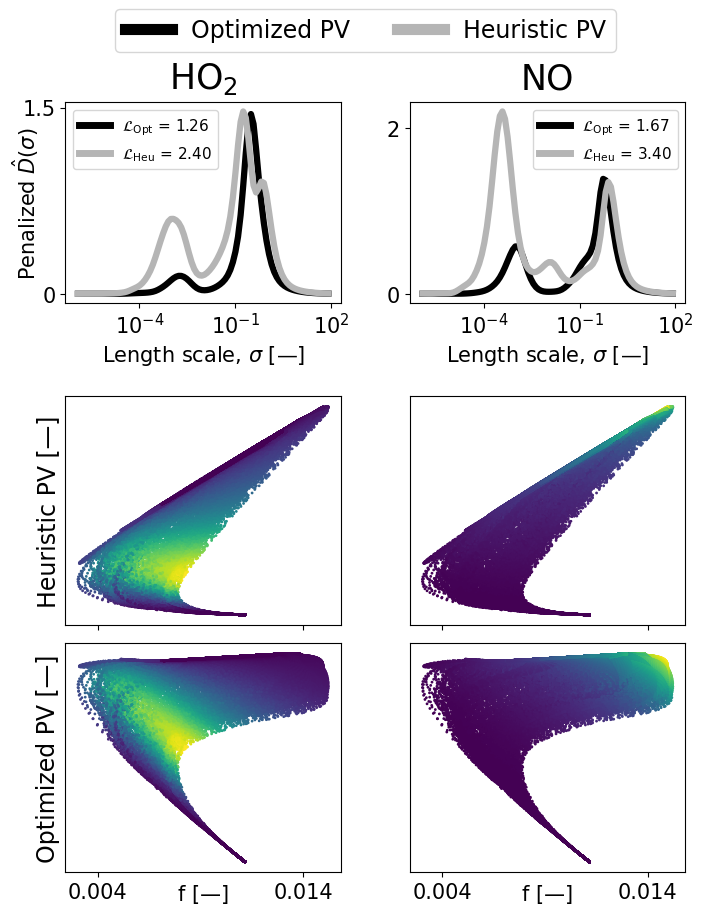

In [ ]:
rows, cols = 3,2

selected_keys = ["HO2", "NO"]

save = True
pathSave = "C:/Users/admin/Documents/Parente/Figures/2024-PV-optimization/Paper/Results/Comparison Xu vs optimized/Manifold and Dhat/"
name = "Manifold and Dhat penalized - DNS - HO2 and NO - PRESENTATION.png"

fig = plt.figure(figsize=(8, 10))
gs = GridSpec(4, 2, width_ratios=[1, 1], height_ratios=[1.4, 0.4, 1.6, 1.6], wspace=0.25, hspace=0.1)

greys = cm.get_cmap('Greys')

for i, key in enumerate(selected_keys):

    ax = fig.add_subplot(gs[0, i])

    idxcost = keys.index(key)

    lineOpt, = ax.plot(bandwidth_values_optimized, derivative_optimized_penalized[i], label=rf'$\mathcal{{L}}_{{\mathrm{{Opt}}}}$ = {costsOptimized[idxcost]:.2f}', color = greys(1.0), zorder = 1, linewidth = 4.5)
    lineHeu, = ax.plot(bandwidth_values_heuristic, derivative_heuristic_penalized[i], label=rf'$\mathcal{{L}}_{{\mathrm{{Heu}}}}$ = {costsHeuristic[idxcost]:.2f}', color = greys(0.4), zorder = 2, linewidth = 4.5, linestyle = "-")
    ax.set_xscale("log")
    
    ax.tick_params(axis="x", labelsize=15)
    ax.set_xlabel(r"Length scale, $\sigma$"+ " [\u2014]", fontsize = 15)
    
    if(i==0):
         ax.set_yticks([0, 1.5])
         ax.set_yticklabels(['0', '1.5'])
    elif(i==1):
         ax.set_yticks([0, 2])

    if(i%cols == 0):
         ax.set_ylabel(r"Penalized $\hat{D}(\sigma)$", fontsize = 15, labelpad=-13)

    ax.tick_params(axis="y", labelsize=15)

    legend_handles = [
                    Line2D([], [], color=greys(1.0), linewidth=5, label=rf'$\mathcal{{L}}_{{\mathrm{{Opt}}}}$ = {costsOptimized[idxcost]:.2f}'),
                    Line2D([], [], color=greys(0.4), linewidth=5, linestyle="-", label=rf'$\mathcal{{L}}_{{\mathrm{{Heu}}}}$ = {costsHeuristic[idxcost]:.2f}')
                         ]
    
    if(key in ["NO2", "PV1"]):
         ax.legend(handles=legend_handles, fontsize = 11)
    else:
         ax.legend(handles=legend_handles, fontsize = 11)

    key_label = key.replace("2", "$_{2}$").replace("1", "$_{source}$")
    ax.set_title(rf"{key_label}", fontsize=25, pad = 10)

    if(key == "HO2"):
         data_color = data_HO2
    elif(key == "NO"):
         data_color = data_NO

    # Heuristic PV
    ax = fig.add_subplot(gs[2, i])
    ax.scatter(data_mf, PV_heuristic, c = data_color, s=1)
    ax.set_xticks([0.004, 0.014])
    ax.set_xticklabels([])
    ax.set_yticks([])
    if(i == 0):
         ax.set_ylabel("Heuristic PV [\u2014]", fontsize = 17)
    box = ax.get_position()
    size = max(box.width, box.height)
    #ax.set_position([box.x0, box.y0, size, size])

    # Optimized PV
    ax = fig.add_subplot(gs[3, i])
    ax.scatter(data_mf, PV_optimized, c = data_color, s=1)
    ax.set_xticks([0.004, 0.014])
    ax.set_xlabel("f [\u2014]", fontsize = 15, labelpad=-13)
    ax.tick_params(axis="x", labelsize=15)
    ax.set_yticks([])
    if(i == 0):
         ax.set_ylabel("Optimized PV [\u2014]", fontsize = 17)
    box = ax.get_position()
    size = max(box.width, box.height)
    #ax.set_position([box.x0, box.y0, size, size])

    if i == 0:
        all_handles = [lineOpt, lineHeu]
        all_labels = [lineOpt.get_label(), lineHeu.get_label()]


legend_handles = [
          Line2D([], [], color=greys(1.0), linewidth=8, label='Optimized PV'),
          Line2D([], [], color=greys(0.4), linewidth=8, linestyle="-", label='Heuristic PV')
               ]

fig.legend(
    handles = legend_handles,
    labels = ["Optimized PV", "Heuristic PV"],
    fontsize=17,
    loc="upper center",
    ncol=2,
    bbox_to_anchor=(0.5, 0.985)
)

if(save):
        plt.savefig(f"{pathSave}{name}", dpi = 300, bbox_inches="tight")
plt.show()

## Autoignition: effect of log(H2O2)

In [11]:
mixture_fractions_train, mixture_fractions_test, state_space_names_0D, state_space_train, state_space_source_train, time_train, state_space_train_np, state_space_source_train_np, state_space_names_DNS = load_0D_data()

In [12]:
PV_heuristic_0D, PV_heuristic_source_0D, _ = load_PV(False, state_space_train_np, state_space_source_train_np, state_space_names_DNS)
PV_optimized_0D, PV_optimized_source_0D, _ = load_PV(True, state_space_train_np, state_space_source_train_np, state_space_names_DNS,
                                               filename_optimized_PV="Xu-AE-opt_adam-epo_100000-lr_0.025-date_14Mar2025-hour_14h23_Tr0D-2q_s0", weight_inversion=True)
PV_optimized_0D_withNOx, PV_optimized_source_0D_withNOx, _ = load_PV(True, state_space_train_np, state_space_source_train_np, state_space_names_DNS,
                                               filename_optimized_PV="Xu-AE-opt_adam-epo_100000-lr_0.025-date_18Feb2025-hour_22h58_Tr0D-2h_s0", weight_inversion=True)
PV_optimized_0D_withoutNOx, PV_optimized_source_0D_withoutNOx, _ = load_PV(True, state_space_train_np, state_space_source_train_np, state_space_names_DNS,
                                               filename_optimized_PV="Xu-AE-opt_adam-epo_100000-lr_0.025-date_15Apr2025-hour_15h37_Tr0D-2v_s0", weight_inversion=True)



In [13]:
name_optimized_0D = "variance_Tr0D-2q_s0-bw_-6_2_100-dataset_autoignition.npy"
name_heuristic_0D = "variance_Xu-bw_-6_2_100-dataset_autoignition.npy"
name_optimized_0D_withNOx = "variance_Tr0D-2h_s0-bw_-6_2_100-dataset_autoignition.npy"
name_optimized_0D_withoutNOx = "variance_Tr0D-2v_s0-bw_-6_2_100-dataset_autoignition.npy"

keys = ['H2O2', 'H2O', 'H2', 'HO2', 'N2O', 'NO2', 'NO', 'O2', 'OH', 'T', 'PV1']

derivative_optimized, bandwidth_values_optimized, max_derivative_optimized = get_variance_data(name_optimized_0D)
derivative_optimized_withoutNOx, bandwidth_values_optimized_withoutNOx, max_derivative_optimized_withoutNOx = get_variance_data(name_optimized_0D_withoutNOx)
derivative_optimized_withNOx, bandwidth_values_optimized_withNOx, max_derivative_optimized_withNOx = get_variance_data(name_optimized_0D_withNOx)
derivative_heuristic, bandwidth_values_heuristic, max_derivative_heuristic = get_variance_data(name_heuristic_0D)

costs_optimized= get_costs(name_optimized_0D)
costs_optimized_withoutNOx = get_costs(name_optimized_0D_withoutNOx)
costs_optimized_withNOx = get_costs(name_optimized_0D_withNOx)
costs_heuristic = get_costs(name_heuristic_0D)

C:\Windows\Temp\ipykernel_14972\3945859918.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  greys = cm.get_cmap('Greys')


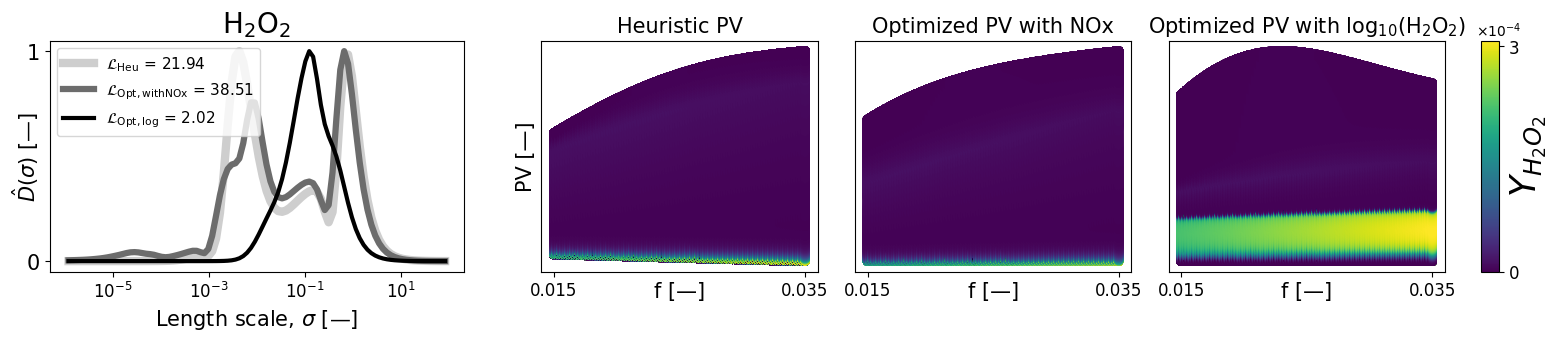

In [ ]:
save = False
pathSave = "C:/Users/admin/Documents/Parente/Figures/2024-PV-optimization/Paper/Results/Comparison Xu vs optimized/Manifold and Dhat/"
name = "Manifold and Dhat - Autoignition - H2O2 - with colorbar - v2.png"

fig = plt.figure(figsize=(18, 3))
gs = GridSpec(1, 5, width_ratios=[1.5, 0.01, 1, 1, 1], wspace=0.15)

greys = cm.get_cmap('Greys')

grey_values = np.linspace(0.3, 1, 3)
lw_values = np.linspace(6, 3, 3)

PV_arrays = [PV_heuristic_0D, PV_optimized_0D_withNOx, PV_optimized_0D]
PV_names = ["Heuristic PV", "Optimized PV with NOx", "Optimized PV with log$_{10}$(H$_2$O$_2$)"]

species_to_inspect = "H2O2"
species_to_inspect_label = "H_{2}O_{2}"
species_to_inspect_latex = species_to_inspect.replace("2", "$_{2}$")

# Create subplots in the grid
for idx in range(5):
    if(idx != 1):
        ax = fig.add_subplot(gs[0, idx])
    
    if idx == 0:
        idxCost = keys.index(species_to_inspect)
        ax.plot(bandwidth_values_heuristic, derivative_heuristic[species_to_inspect], lw = lw_values[0],
                label=f"$\mathcal{{L}}_{{\mathrm{{Heu}}}}$ = {costs_heuristic[idxCost]:.2f}", color=greys(grey_values[0]))
        ax.plot(bandwidth_values_optimized_withNOx, derivative_optimized_withNOx[species_to_inspect], lw = lw_values[1],
                label=f"$\mathcal{{L}}_{{\mathrm{{Opt, with NOx}}}}$ = {costs_optimized_withNOx[idxCost]:.2f}", color=greys(grey_values[1]))
        ax.plot(bandwidth_values_optimized, derivative_optimized[species_to_inspect], lw = lw_values[2],
                label=f"$\mathcal{{L}}_{{\mathrm{{Opt, log}}}}$ = {costs_optimized[idxCost]:.2f}", color=greys(grey_values[2]))
        ax.legend(fontsize = 11)
        ax.set_xscale("log")
        ax.tick_params(axis="x", labelsize=12)
        ax.set_xlabel(r"Length scale, $\sigma$"+ " [\u2014]", fontsize = 15)
        ax.set_yticks([0, 1])
        ax.set_ylabel(rf"$\hat{{D}}(\sigma)$" + " [\u2014]", fontsize = 15, labelpad = -10)
        ax.set_title(species_to_inspect_latex, fontsize = 20)
        ax.tick_params(axis="y", labelsize=15)

    elif idx in [2, 3, 4]:
        sc = ax.scatter(mixture_fractions_train, PV_arrays[idx-2], c = state_space_train[species_to_inspect])
        ax.set_title(PV_names[idx-2], fontsize = 15)
        ax.set_xticks([0.015, 0.035])
        ax.set_yticks([])
        ax.tick_params(axis = "x", labelsize = 12)
        ax.set_xlabel("f [\u2014]", fontsize = 15, labelpad=-13)
        if(idx == 2):
            ax.set_ylabel("PV [\u2014]", fontsize = 15)
        if(idx == 4):
            cbar_ax = fig.add_axes([0.92, 0.11, 0.01, 0.77])  # [left, bottom, width, height] in figure coords
            cbar = fig.colorbar(sc, cax=cbar_ax)
            cbar.set_label(f'$Y_{{{species_to_inspect_label}}}$', fontsize=25, rotation = 90, labelpad = -8)
            cbar.set_ticks([0, 0.0003])
            formatter = ScalarFormatter(useMathText=True)
            formatter.set_powerlimits((0, 0))  # Forces scientific notation only when needed
            formatter.set_useOffset(False)     # Avoids +1e-4 style offset
            cbar.ax.yaxis.set_major_formatter(formatter)
            offset_text = cbar.ax.yaxis.get_offset_text()
            offset_text.set_x(offset_text.get_position()[0] + 1.25)
            cbar.ax.tick_params(labelsize=12)
if(save):
        plt.savefig(f"{pathSave}{name}", dpi = 300, bbox_inches="tight")
plt.show()

C:\Windows\Temp\ipykernel_8016\3147559102.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  greys = cm.get_cmap('Greys')


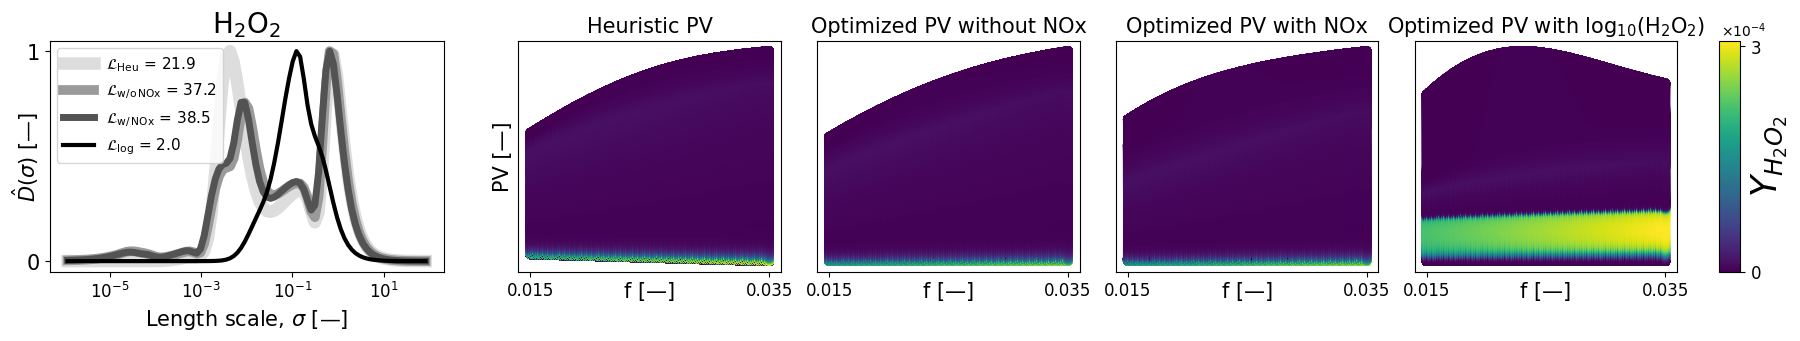

In [ ]:
save = True
pathSave = "C:/Users/admin/Documents/Parente/Figures/2024-PV-optimization/Paper/Results/Comparison Xu vs optimized/Manifold and Dhat/"
name = "Manifold and Dhat - Autoignition - H2O2 - with colorbar - extended.png"

fig = plt.figure(figsize=(21, 3))
gs = GridSpec(1, 6, width_ratios=[1.5, 0.01, 1, 1, 1, 1], wspace=0.15)

greys = cm.get_cmap('Greys')

grey_values = np.linspace(0.23, 1, 4)
lw_values = np.linspace(9, 3, 4)

PV_arrays = [PV_heuristic_0D, PV_optimized_0D_withoutNOx, PV_optimized_0D_withNOx, PV_optimized_0D]
PV_names = ["Heuristic PV", "Optimized PV without NOx", "Optimized PV with NOx", "Optimized PV with log$_{10}$(H$_2$O$_2$)"]

species_to_inspect = "H2O2"
species_to_inspect_label = "H_{2}O_{2}"
species_to_inspect_latex = species_to_inspect.replace("2", "$_{2}$")

# Create subplots in the grid
for idx in range(6):
    if(idx != 1):
        ax = fig.add_subplot(gs[0, idx])
    
    if idx == 0:
        idxCost = keys.index(species_to_inspect)
        ax.plot(bandwidth_values_heuristic, derivative_heuristic[species_to_inspect], lw = lw_values[0],
                label=f"$\mathcal{{L}}_{{\mathrm{{Heu}}}}$ = {costs_heuristic[idxCost]:.1f}", color=greys(grey_values[0]))
        ax.plot(bandwidth_values_optimized_withoutNOx, derivative_optimized_withoutNOx[species_to_inspect], lw = lw_values[1],
                label=f"$\mathcal{{L}}_{{\mathrm{{w/o\, NOx}}}}$ = {costs_optimized_withoutNOx[idxCost]:.1f}", color=greys(grey_values[1]))
        ax.plot(bandwidth_values_optimized_withNOx, derivative_optimized_withNOx[species_to_inspect], lw = lw_values[2],
                label=f"$\mathcal{{L}}_{{\mathrm{{w/\, NOx}}}}$ = {costs_optimized_withNOx[idxCost]:.1f}", color=greys(grey_values[2]))
        ax.plot(bandwidth_values_optimized, derivative_optimized[species_to_inspect], lw = lw_values[3],
                label=f"$\mathcal{{L}}_{{\mathrm{{log}}}}$ = {costs_optimized[idxCost]:.1f}", color=greys(grey_values[3]))
        ax.legend(fontsize = 11)

        ax.set_xscale("log")
        ax.tick_params(axis="x", labelsize=12)
        ax.set_xlabel(r"Length scale, $\sigma$"+ " [\u2014]", fontsize = 15)
        ax.set_yticks([0, 1])
        ax.set_ylabel(rf"$\hat{{D}}(\sigma)$" + " [\u2014]", fontsize = 15, labelpad = -10)
        ax.set_title(species_to_inspect_latex, fontsize = 20)
        ax.tick_params(axis="y", labelsize=15)

    elif idx in [2, 3, 4, 5]:
        sc = ax.scatter(mixture_fractions_train, PV_arrays[idx-2], c = state_space_train[species_to_inspect])
        ax.set_title(PV_names[idx-2], fontsize = 15)
        ax.set_xticks([0.015, 0.035])
        ax.set_yticks([])
        ax.tick_params(axis = "x", labelsize = 12)
        ax.set_xlabel("f [\u2014]", fontsize = 15, labelpad=-13)
        if(idx == 2):
            ax.set_ylabel("PV [\u2014]", fontsize = 15)
        if(idx == 4):
            cbar_ax = fig.add_axes([0.92, 0.11, 0.01, 0.77])  # [left, bottom, width, height] in figure coords
            cbar = fig.colorbar(sc, cax=cbar_ax)
            cbar.set_label(f'$Y_{{{species_to_inspect_label}}}$', fontsize=25, rotation = 90, labelpad = -8)
            cbar.set_ticks([0, 0.0003])
            formatter = ScalarFormatter(useMathText=True)
            formatter.set_powerlimits((0, 0))  # Forces scientific notation only when needed
            formatter.set_useOffset(False)     # Avoids +1e-4 style offset
            cbar.ax.yaxis.set_major_formatter(formatter)
            offset_text = cbar.ax.yaxis.get_offset_text()
            offset_text.set_x(offset_text.get_position()[0] + 1.25)
            cbar.ax.tick_params(labelsize=12)
if(save):
        plt.savefig(f"{pathSave}{name}", dpi = 1000, bbox_inches="tight")
plt.show()

## Paper: combine H2O2 and NO

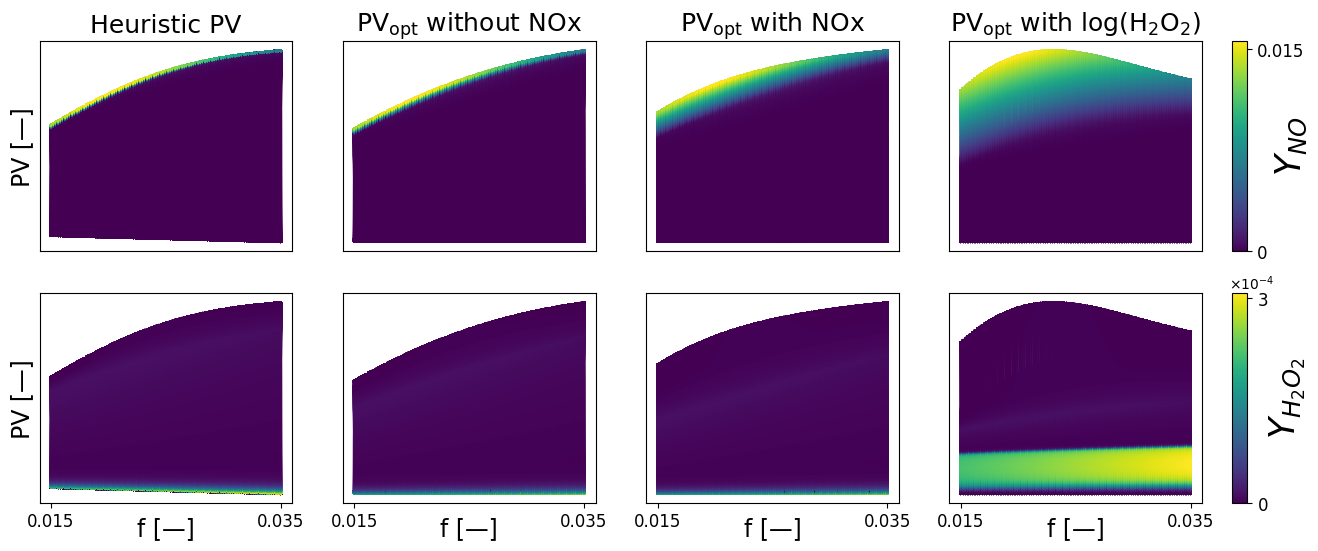

In [ ]:
list_species_to_inspect = ["NO", "H2O2"]

save = True
path = "C:/Users/Admin/Documents/Parente/Figures/2024-PV-optimization/Paper/Results/Effect QoI NOx/f-PV manifolds/" #"Autoignition/Z_0.015-0.035-T_900K/f-PV manifolds/"
name = f"Evolution NO and H2O2 distribution in f-PV manifolds - heuristic and optimized PVs.png"

modelNames =   ["Xu-AE-opt_adam-epo_100000-lr_0.025-date_15Apr2025-hour_15h37_Tr0D-2v_s0", #Without NOx
                "Xu-AE-opt_adam-epo_100000-lr_0.025-date_18Feb2025-hour_22h58_Tr0D-2h_s0", #With NOx
                "Xu-AE-opt_adam-epo_100000-lr_0.025-date_14Mar2025-hour_14h23_Tr0D-2q_s0"] #With log(H2O2)]
PV_optimized_names = ["without NOx", "with NOx", "with log(H$_2$O$_2$)"]
weight_inversionArray = [True, True, True]

fig, axes = plt.subplots(2, 4, figsize=(15, 6))  # 1 row, 4 columns
#axes = axes.flatten()

for idxSpecies, species_to_inspect in enumerate(list_species_to_inspect):

    ax_heu = axes[idxSpecies, 0]

    ax_heu.scatter(mixture_fractions_train, PV_heuristic_0D, s=1, c=state_space_train[species_to_inspect])
    if(idxSpecies == 0):
        ax_heu.set_title("Heuristic PV", fontsize = 18)
        ax_heu.set_xticks([])
    else:
        ax_heu.set_xlabel("f [\u2014]", fontsize = 17, labelpad = -10)
        ax_heu.set_xticks([0.015, 0.035])
    ax_heu.set_ylabel("PV [\u2014]", fontsize = 17)
    ax_heu.set_yticks([])
    ax_heu.tick_params(axis='x', labelsize=12)


    for idx, (ax, filename_model, PV_optimized_name) in enumerate(zip(axes[idxSpecies, 1:], modelNames, PV_optimized_names), start=0):

        filename_metadata = filename_model + "_metadata.pkl"
        path_metadata = "metadata/"
        filename_species_names = "Xu-state-space-names.csv"
        path_data = "data-files/"

        loader = loadData(filename_species_names, path_metadata, filename_metadata)
        idx_species_removed = loader.metadata["list idx species removed source"] if loader.metadata["dataset_type"]=="autoignition_augm" else loader.metadata["idx species removed"]
        id_model = loader.metadata["Training_id"]
        model = loader.loadModel()

        weight_inversion = weight_inversionArray[idx]
        if(weight_inversion):
            with torch.no_grad():  # Ensures we do not track gradients for this operation
                model.encoder_species.weight.mul_(-1)

        state_space_names_DNS = np.genfromtxt(f"{path_data}Xu-state-space-names.csv", delimiter=",", dtype=str)

        #create a np array in the format for the DNS dataset/optimized PV
        state_space_train_DNS = state_space_train[state_space_names_DNS].to_numpy()
        state_space_source_train_DNS = state_space_source_train[state_space_names_DNS].to_numpy()

        PV_optimized_train = model.get_PV(torch.from_numpy(np.delete(state_space_train_DNS, idx_species_removed, axis=1))).detach().numpy()
        PV_optimized_source_train = model.get_PV(torch.from_numpy(np.delete(state_space_source_train_DNS, idx_species_removed, axis=1))).detach().numpy()

        sc = ax.scatter(mixture_fractions_train, PV_optimized_train, s=1, c=state_space_train[species_to_inspect])
        
        if(idxSpecies == 0):
            ax.set_title(f"PV$_{{\\mathrm{{opt}}}}$ {PV_optimized_name}", fontsize = 18)   #PV$_{{\\mathrm{{opt}}}}$
            ax.set_xticks([])
        else:
            ax.set_xlabel("f [\u2014]", fontsize = 17, labelpad = -10)
            ax.set_xticks([0.015, 0.035])
        ax.set_yticks([])
        ax.tick_params(axis='x', labelsize=12)


    if(idxSpecies == 0):
        cbar_ax = fig.add_axes([0.92, 0.53, 0.01, 0.35])  # [left, bottom, width, height] in figure coords
        cbar = fig.colorbar(sc, cax=cbar_ax)
        cbar.set_label(f"$Y_{{{species_to_inspect.replace('2', '_2')}}}$", fontsize=25, rotation = 90, labelpad = -22)
        cbar.set_ticks([0, 0.015])
        cbar.ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x:g}"))
        cbar.ax.tick_params(labelsize=12)
    else:
        cbar_ax = fig.add_axes([0.92, 0.11, 0.01, 0.35])  # [left, bottom, width, height] in figure coords
        cbar = fig.colorbar(sc, cax=cbar_ax)
        cbar.set_label(f"$Y_{{{species_to_inspect.replace('2', '_2')}}}$", fontsize=25, rotation = 90, labelpad = 0)
        cbar.set_ticks([0, 0.0003])
        formatter = ScalarFormatter(useMathText=True)
        formatter.set_scientific(True)
        formatter.set_powerlimits((-4, -4))  # Force e-04 notation
        cbar.ax.yaxis.set_major_formatter(formatter)
        cbar.ax.yaxis.get_offset_text().set_x(2.8)
        cbar.ax.tick_params(labelsize=12)


if(save):
    plt.savefig(path + name, dpi = 1000, bbox_inches='tight')
plt.show()

C:\Windows\Temp\ipykernel_15408\2701502732.py:100: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  greys = cm.get_cmap('Greys')
C:\Windows\Temp\ipykernel_15408\2701502732.py:175: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  greys = cm.get_cmap('Greys')


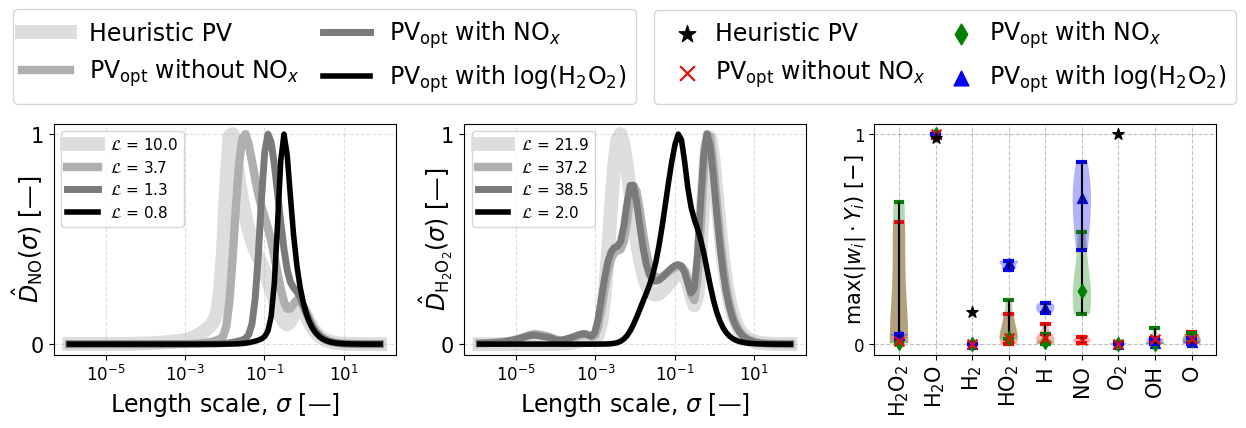

In [ ]:
save = True
path = "C:/Users/Admin/Documents/Parente/Figures/2024-PV-optimization/Paper/Results/Effect QoI NOx/Overview/" #"Autoignition/Z_0.015-0.035-T_900K/f-PV manifolds/"
name = f"Dhat NO - Dhat H2O2 - weights - heuristic and optimized PVs.png"
namePdf= f"Dhat NO - Dhat H2O2 - weights - heuristic and optimized PVs.pdf"

rows, cols = 1, 3

fig, axes = plt.subplots(rows, cols, figsize=(15, 3))  # Define the grid
axes = axes.flatten()

species_to_inspect = "NO"

filename_autoignition = "isochoric-adiabatic-closed-HR-H2-air-lin_Z_0.015_0.035_100-T0_900-"
path_data_autoignition = "data-files/autoignition/"

state_space_names_0D = np.genfromtxt(f"{path_data_autoignition}{filename_autoignition}state-space-names.csv", delimiter=",", dtype=str)

######################
# Model with log(H2O2)

filename_model = "Xu-AE-opt_adam-epo_100000-lr_0.025-date_14Mar2025-hour_14h23_Tr0D-2q_s0"
filename_metadata = filename_model + "_metadata.pkl"
path_metadata = "metadata/"
filename_species_names = "Xu-state-space-names.csv"
path_data = "data-files/"
loader = loadData(filename_species_names, path_metadata, filename_metadata)
idx_species_removed = loader.metadata["list idx species removed source"] if loader.metadata["dataset_type"].startswith("autoignition_augm") else loader.metadata["idx species removed"]
id_model = loader.metadata["Training_id"]
model = loader.loadModel()

weight_inversion = True
if(weight_inversion):
    with torch.no_grad():  # Ensures we do not track gradients for this operation
        model.encoder_species.weight.mul_(-1)

######################
# Model with NOx

filename_model = "Xu-AE-opt_adam-epo_100000-lr_0.025-date_18Feb2025-hour_22h58_Tr0D-2h_s0"
filename_metadata = filename_model + "_metadata.pkl"
path_metadata = "metadata/"
filename_species_names = "Xu-state-space-names.csv"
path_data = "data-files/"
loader = loadData(filename_species_names, path_metadata, filename_metadata)
idx_species_removed_withNOx = loader.metadata["list idx species removed source"] if loader.metadata["dataset_type"].startswith("autoignition_augm") else loader.metadata["idx species removed"]
id_model = loader.metadata["Training_id"]
model_withNOx = loader.loadModel()

weight_inversion = True
if(weight_inversion):
    with torch.no_grad():  # Ensures we do not track gradients for this operation
        model_withNOx.encoder_species.weight.mul_(-1)


######################
# Model without NOx

filename_model = "Xu-AE-opt_adam-epo_100000-lr_0.025-date_15Apr2025-hour_15h37_Tr0D-2v_s0"
filename_metadata = filename_model + "_metadata.pkl"
path_metadata = "metadata/"
filename_species_names = "Xu-state-space-names.csv"
path_data = "data-files/"
loader = loadData(filename_species_names, path_metadata, filename_metadata)
idx_species_removed_withoutNOx = loader.metadata["list idx species removed source"] if loader.metadata["dataset_type"].startswith("autoignition_augm") else loader.metadata["idx species removed"]
id_model = loader.metadata["Training_id"]
model_withoutNOx = loader.loadModel()

weight_inversion = True
if(weight_inversion):
    with torch.no_grad():  # Ensures we do not track gradients for this operation
        model_withoutNOx.encoder_species.weight.mul_(-1)


##################
# Import data

state_space_names_DNS = np.genfromtxt(f"{path_data}Xu-state-space-names.csv", delimiter=",", dtype=str)

idxTraj = 4

#test state space
with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
    test_trajectory = pd.DataFrame(hf[f'test_trajectory_{idxTraj}'][:], columns = state_space_names_0D)
    PV_Xu_test = test_trajectory["H2O"] - test_trajectory["H2"] - test_trajectory["O2"]
    PV_Xu_test = (PV_Xu_test - PV_Xu_test.min()) / (PV_Xu_test.max() - PV_Xu_test.min())
    PV_Xu_test = PV_Xu_test.to_numpy()

    state_space_test_DNS = test_trajectory[state_space_names_DNS].to_numpy()

    PV_optimized_test = model.get_PV(torch.from_numpy(np.delete(state_space_test_DNS, idx_species_removed, axis=1))).detach().numpy()
    PV_optimized_test = (PV_optimized_test - PV_optimized_test.min())/(PV_optimized_test.max() - PV_optimized_test.min())

    PV_optimized_test_withNOx = model_withNOx.get_PV(torch.from_numpy(np.delete(state_space_test_DNS, idx_species_removed_withNOx, axis=1))).detach().numpy()
    PV_optimized_test_withNOx = (PV_optimized_test_withNOx - PV_optimized_test_withNOx.min())/(PV_optimized_test_withNOx.max() - PV_optimized_test_withNOx.min())

    PV_optimized_test_withoutNOx = model_withoutNOx.get_PV(torch.from_numpy(np.delete(state_space_test_DNS, idx_species_removed_withoutNOx, axis=1))).detach().numpy()
    PV_optimized_test_withoutNOx = (PV_optimized_test_withoutNOx - PV_optimized_test_withoutNOx.min())/(PV_optimized_test_withoutNOx.max() - PV_optimized_test_withoutNOx.min())


greys = cm.get_cmap('Greys')

list_greys = [greys(0.23), greys(0.42), greys(0.6), greys(1.0)]
list_linewidth = [10, 6, 5, 4]
list_zorder = [1, 2, 3, 4]

species_label = species_to_inspect.replace("2", "_{2}").replace("1", "_{source}")



##########################################################################################################################
########################################################## Dhat curves ###################################################
##########################################################################################################################

path_variance = "data-files/costs/"

name_withNOx = "variance_Tr0D-2h_s0-bw_-6_2_100-dataset_autoignition.npy"


penalty_function = 'log-sigma-over-peak'
power = 4
vertical_shift = 1

name_optimized_0D = "variance_Tr0D-2q_s0-bw_-6_2_100-dataset_autoignition.npy"
name_heuristic_0D = "variance_Xu-bw_-6_2_100-dataset_autoignition.npy"

variance_optimized_0D = np.load(f"{path_variance}{name_optimized_0D}", allow_pickle=True).item()
variance_heuristic_0D = np.load(f"{path_variance}{name_heuristic_0D}", allow_pickle=True).item()

(derivative_optimized_0D, bandwidth_values_optimized_0D, max_derivative_optimized_0D) = normalized_variance_derivative(variance_optimized_0D)
(derivative_heuristic_0D, bandwidth_values_heuristic_0D, max_derivative_heuristic_0D) = normalized_variance_derivative(variance_heuristic_0D)

costsOptimized_0D = cost_function_normalized_variance_derivative(variance_optimized_0D,
                                                            penalty_function=penalty_function,
                                                            power=power,
                                                            vertical_shift=vertical_shift,
                                                            norm=None)
costsHeuristic_0D = cost_function_normalized_variance_derivative(variance_heuristic_0D,
                                                            penalty_function=penalty_function,
                                                            power=power,
                                                            vertical_shift=vertical_shift,
                                                            norm=None)



variance_withNOx = np.load(f"{path_variance}{name_withNOx}", allow_pickle=True).item()

(derivative_withNOx, bandwidth_values_withNOx, max_derivative_withNOx) = normalized_variance_derivative(variance_withNOx)

keys = ['H2O2', 'H2O', 'H2', 'HO2', 'N2O', 'NO2', 'NO', 'O2', 'OH', 'T', 'PV1']

costsWithNOx = cost_function_normalized_variance_derivative(variance_withNOx,
                                                            penalty_function=penalty_function,
                                                            power=power,
                                                            vertical_shift=vertical_shift,
                                                            norm=None)



seed_2v = 0
name_withoutNOx = f"variance_Tr0D-2v_s{seed_2v}-bw_-6_2_100-dataset_autoignition.npy"

variance_withoutNOx = np.load(f"{path_variance}{name_withoutNOx}", allow_pickle=True).item()

(derivative_withoutNOx, bandwidth_values_withoutNOx, max_derivative_withoutNOx) = normalized_variance_derivative(variance_withoutNOx)

costsWithoutNOx = cost_function_normalized_variance_derivative(variance_withoutNOx,
                                                            penalty_function=penalty_function,
                                                            power=power,
                                                            vertical_shift=vertical_shift,
                                                            norm=None)

import matplotlib.cm as cm

# Get shades of grey from black (0) to white (1)
greys = cm.get_cmap('Greys')

ax_Dhat = axes[0]

idx = keys.index(species_to_inspect)

ax_Dhat.plot(bandwidth_values_heuristic_0D, derivative_heuristic_0D[species_to_inspect],
        linewidth=list_linewidth[0], linestyle="-", label=f"$\mathcal{{L}}$ = {costsHeuristic_0D[idx]:.1f}", color=list_greys[0], zorder=list_zorder[0])
ax_Dhat.plot(bandwidth_values_withoutNOx, derivative_withoutNOx[species_to_inspect],
        linewidth=list_linewidth[1], label=f"$\mathcal{{L}}$ = {costsWithoutNOx[idx]:.1f}", color=list_greys[1], linestyle="-", zorder=list_zorder[1])
ax_Dhat.plot(bandwidth_values_withNOx, derivative_withNOx[species_to_inspect],
        linewidth=list_linewidth[2], label=f"$\mathcal{{L}}$ = {costsWithNOx[idx]:.1f}", color=list_greys[2], zorder=list_zorder[2])
ax_Dhat.plot(bandwidth_values_optimized_0D, derivative_optimized_0D[species_to_inspect],
        linewidth=list_linewidth[3], label=f"$\mathcal{{L}}$ = {costsOptimized_0D[idx]:.1f}", color=list_greys[3], zorder=list_zorder[3])
ax_Dhat.set_xscale("log")
ax_Dhat.grid(True, linestyle='--', alpha=0.4)

ax_Dhat.legend(loc = "upper left", fontsize = 11)


ax_Dhat.tick_params(axis="both", labelsize=12)
ax_Dhat.set_xlabel(r"Length scale, $\sigma$"+ " [\u2014]", fontsize = 17)


ax_Dhat.set_yticks([0, 1])
ax_Dhat.set_ylabel(f"$\hat{{D}}_{{\\mathrm{{{species_to_inspect}}}}}(\sigma)$" + " [\u2014]", fontsize = 17, labelpad = -10)

ax_Dhat.tick_params(axis="y", labelsize=15)



species_to_inspect = "H2O2"
species_to_inspect_latex = species_to_inspect.replace('2', '_2')

ax_Dhat = axes[1]

idx = keys.index(species_to_inspect)

ax_Dhat.plot(bandwidth_values_heuristic_0D, derivative_heuristic_0D[species_to_inspect],
        linewidth=list_linewidth[0], linestyle="-", label=f"$\mathcal{{L}}$ = {costsHeuristic_0D[idx]:.1f}", color=list_greys[0], zorder=list_zorder[0])
ax_Dhat.plot(bandwidth_values_withoutNOx, derivative_withoutNOx[species_to_inspect],
        linewidth=list_linewidth[1], label=f"$\mathcal{{L}}$ = {costsWithoutNOx[idx]:.1f}", color=list_greys[1], linestyle="-", zorder=list_zorder[1])
ax_Dhat.plot(bandwidth_values_withNOx, derivative_withNOx[species_to_inspect],
        linewidth=list_linewidth[2], label=f"$\mathcal{{L}}$ = {costsWithNOx[idx]:.1f}", color=list_greys[2], zorder=list_zorder[2])
ax_Dhat.plot(bandwidth_values_optimized_0D, derivative_optimized_0D[species_to_inspect],
        linewidth=list_linewidth[3], label=f"$\mathcal{{L}}$ = {costsOptimized_0D[idx]:.1f}", color=list_greys[3], zorder=list_zorder[3])
ax_Dhat.set_xscale("log")
ax_Dhat.grid(True, linestyle='--', alpha=0.4)

ax_Dhat.legend(loc = "upper left", fontsize = 11)


ax_Dhat.tick_params(axis="both", labelsize=12)
ax_Dhat.set_xlabel(r"Length scale, $\sigma$"+ " [\u2014]", fontsize = 17)


ax_Dhat.set_yticks([0, 1])
ax_Dhat.set_ylabel(f"$\hat{{D}}_{{\\mathrm{{{species_to_inspect_latex}}}}}(\sigma)$" + " [\u2014]", fontsize = 17, labelpad = -10)

ax_Dhat.tick_params(axis="y", labelsize=15)



legend_lines = [
    Line2D([0], [0], color=list_greys[0], linewidth=list_linewidth[0], label="Heuristic PV", zorder=list_zorder[0]),
    Line2D([0], [0], color=list_greys[1], linewidth=list_linewidth[1], label="PV$_{\mathrm{opt}}$ without NO$_x$", zorder=list_zorder[1]),
    Line2D([0], [0], color=list_greys[2], linewidth=list_linewidth[2], label="PV$_{\mathrm{opt}}$ with NO$_x$", zorder=list_zorder[2]),
    Line2D([0], [0], color=list_greys[3], linewidth=list_linewidth[3], label="PV$_{\mathrm{opt}}$ with log(H$_2$O$_2$)", zorder=list_zorder[3]),
]
fig.legend(legend_lines, [line.get_label() for line in legend_lines], loc='upper left', ncol=2, fontsize=17, frameon=True, bbox_to_anchor=(0.09, 1.3), markerscale=8, columnspacing=1)


##########################################################################################################################
########################################################## WEIGHTS #######################################################
##########################################################################################################################

dataset = "autoignition"

abs = True #in absolute value otherwise jumps from -1 to 1/sign flips for the different species

path_state = path_data + f"Xu-state-space-{dataset}.csv"
nbrSeeds = 5

nameModels = ["Xu-AE-opt_adam-epo_100000-lr_0.025-date_14Mar2025-hour_14h23_Tr0D-2q_s",
              "Xu-AE-opt_adam-epo_100000-lr_0.025-date_18Feb2025-hour_22h58_Tr0D-2h_s",              
              "Xu-AE-opt_adam-epo_100000-lr_0.025-date_15Apr2025-hour_15h37_Tr0D-2v_s"]

########################
# Heuristic PV

my_species_Xu = Species(path_data)

list_species_Xu = my_species_Xu.get_list_species()
for index in sorted(idx_species_removed, reverse=True): #same species to remove
    list_species_Xu.pop(index)

final_weights_Xu = np.zeros(19)
final_weights_Xu[list_species_Xu.index("H2O")] = 1
final_weights_Xu[list_species_Xu.index("H2")] = -1
final_weights_Xu[list_species_Xu.index("O2")] = -1

#get mass fractions of species
state_space_Xu = pd.read_csv(path_state, header = "infer")
state_space_Xu = state_space_Xu.drop(state_space_Xu.columns[idx_species_removed], axis=1)
state_space_matrix_Xu = state_space_Xu.to_numpy()

wi_Yi_Xu = state_space_matrix_Xu*np.abs(final_weights_Xu) #|w_i|*Y_i
if(abs):
    max_wi_Yi_Xu = np.max(wi_Yi_Xu, axis = 0) #take max of every species
else:
    max_wi_Yi_Xu = np.sign(final_weights_Xu)*np.max(wi_Yi_Xu, axis = 0) #take max of every species

max_wi_Yi_scaled_Xu = max_wi_Yi_Xu/np.max(np.abs(max_wi_Yi_Xu))



weightsSpecies = np.zeros((nbrSeeds, len(final_weights_Xu)))
weightsSpeciesWithNOx = np.zeros((nbrSeeds, len(final_weights_Xu)))
weightsSpeciesWithoutNOx = np.zeros((nbrSeeds, len(final_weights_Xu)))

#########################
# Start Figure
                 
for idxSeed in range(nbrSeeds):

    for idxModel, modelName in enumerate(nameModels):

        filename_model = f"{modelName}{idxSeed}"
        filename_metadata_0D = filename_model + "_metadata.pkl"

        loader_0D = loadData(filename_species_names, path_metadata, filename_metadata_0D)
        output_idx = loader_0D.metadata["list idx species removed source"] if loader_0D.metadata["dataset_type"].startswith("autoignition_augm") else loader_0D.metadata["idx species removed"]
        idx_species_removed = loader_0D.metadata["list idx species removed source"] if loader_0D.metadata["dataset_type"].startswith("autoignition_augm") else loader_0D.metadata["idx species removed"]
        input_scaling = loader_0D.metadata["input scaling"]
        input_species_scaling = loader_0D.metadata["input species scaling"]
        input_species_bias = loader_0D.metadata["input species bias"]
        range_mf  = loader_0D.metadata["range_mf"]
        depvar_names_species = loader_0D.metadata["list species output"]
        depvar_names_idx = loader_0D.metadata["output elements"]
        PV_dim = loader_0D.metadata["PV dim"]
        depvar_names = depvar_names_species + depvar_names_idx[-(PV_dim+1):]
        model_0D = loader_0D.loadModel()
        id = loader_0D.metadata["Training_id"]
        nbr_input_species = loader_0D.metadata["nbr input species"]

        final_weights = model_0D.get_total_encoder_weights(npy = True)[0]

        #get index spcies removed
        my_species = Species(path_data)

        list_species = my_species.get_list_species()
        for index in sorted(idx_species_removed, reverse=True):
            list_species.pop(index)

        #get mass fractions of species
        state_space = pd.read_csv(path_state, header = "infer")
        state_space = state_space.drop(state_space.columns[idx_species_removed], axis=1)
        state_space_matrix = state_space.to_numpy()

        wi_Yi = state_space_matrix*np.abs(final_weights) #|w_i|*Y_i
        if(abs):
            max_wi_Yi = np.max(wi_Yi, axis = 0) #take max of every species
        else:
            max_wi_Yi = np.sign(final_weights)*np.max(wi_Yi, axis = 0) #take max of every species

        max_wi_Yi_scaled = max_wi_Yi/np.max(np.abs(max_wi_Yi))

        if(idxModel == 0):
            weightsSpecies[idxSeed, :] = max_wi_Yi_scaled
        elif(idxModel == 1):
            weightsSpeciesWithNOx[idxSeed, :] = max_wi_Yi_scaled
        else:
            weightsSpeciesWithoutNOx[idxSeed, :] = max_wi_Yi_scaled


#################
#Plot the weights
#################

ax_weights = axes[2]

mediansWithoutNOx = np.median(weightsSpeciesWithoutNOx, axis=0)
mediansWithNOx = np.median(weightsSpeciesWithNOx, axis=0)
mediansWithLogH2O2 = np.median(weightsSpecies, axis=0)

valid_indices = [i for i in range(len(max_wi_Yi_scaled)) if np.abs(mediansWithoutNOx[i]) > 0.01 or np.abs(mediansWithNOx[i])>0.01 or np.abs(mediansWithLogH2O2[i])>0.01 or np.abs(max_wi_Yi_scaled_Xu[i]) > 0.01]


latex_species_list = np.array([s.replace('2', r'$_2$').replace('3', r'$_3$') for s in list_species])
latex_species_list_filtered = latex_species_list[valid_indices]

max_wi_Yi_scaled_Xu_filtered = max_wi_Yi_scaled_Xu[valid_indices]

non_zero_mask = max_wi_Yi_scaled_Xu_filtered != 0
positions = np.arange(len(max_wi_Yi_scaled_Xu_filtered))


# Heuristic PV
ax_weights.scatter(
    np.arange(len(max_wi_Yi_scaled_Xu_filtered))[non_zero_mask],
    max_wi_Yi_scaled_Xu_filtered[non_zero_mask],
    color="k", label="Heuristic PV", marker="*", s=70, zorder = 4
)




# Without NOx
violinWithout = ax_weights.violinplot(weightsSpeciesWithoutNOx[:, valid_indices], positions, widths = 0.5)
for element in violinWithout["bodies"]:
    element.set_facecolor("red")
    element.set_linewidth(10)
violinWithout['cmins'].set_color('red')
violinWithout['cmaxes'].set_color('red')
violinWithout['cbars'].set_color('black')
medians = np.median(weightsSpeciesWithoutNOx[:, valid_indices], axis=0)

violinWithout['cmaxes'].set_linewidth(3)
violinWithout['cmins'].set_linewidth(3)

for i, (cmin, cmax) in enumerate(zip(violinWithout['cmins'].get_segments(), violinWithout['cmaxes'].get_segments())):
    # Extract y-values (vertical limits)
    y_min = cmin[0][1]
    y_max = cmax[0][1]

    # Use actual position
    x_center = positions[i]
    width = 0.15  # desired width of the extrema bars

    # Set new segments for min and max bars
    violinWithout['cmins'].set_segments([
        [[x_center - width, seg[0][1]], [x_center + width, seg[0][1]]]
        for seg, x_center in zip(violinWithout['cmins'].get_segments(), positions)
    ])
    violinWithout['cmaxes'].set_segments([
        [[x_center - width, seg[0][1]], [x_center + width, seg[0][1]]]
        for seg, x_center in zip(violinWithout['cmaxes'].get_segments(), positions)
    ])


ax_weights.scatter(positions, medians, color = "red", marker='x', s=50, zorder=3, label='PV$_{\mathrm{opt}}$ without NO$_x$') #red  greys(0.6)





# With NOx
violinWith = ax_weights.violinplot(weightsSpeciesWithNOx[:, valid_indices], positions, widths = 0.5)
for element in violinWith["bodies"]:
    element.set_facecolor("green")
    element.set_linewidth(10)
violinWith['cmins'].set_color('green')
violinWith['cmaxes'].set_color('green')
violinWith['cbars'].set_color('black')
medians = np.median(weightsSpeciesWithNOx[:, valid_indices], axis=0)

violinWith['cmaxes'].set_linewidth(3)
violinWith['cmins'].set_linewidth(3)

for i, (cmin, cmax) in enumerate(zip(violinWith['cmins'].get_segments(), violinWith['cmaxes'].get_segments())):
    # Extract y-values (vertical limits)
    y_min = cmin[0][1]
    y_max = cmax[0][1]

    # Use actual position
    x_center = positions[i]
    width = 0.15  # desired width of the extrema bars

    # Set new segments for min and max bars
    violinWith['cmins'].set_segments([
        [[x_center - width, seg[0][1]], [x_center + width, seg[0][1]]]
        for seg, x_center in zip(violinWith['cmins'].get_segments(), positions)
    ])
    violinWith['cmaxes'].set_segments([
        [[x_center - width, seg[0][1]], [x_center + width, seg[0][1]]]
        for seg, x_center in zip(violinWith['cmaxes'].get_segments(), positions)
    ])

plt.scatter(positions, medians, color="green", marker='d', s=50, zorder=2, label='PV$_{\mathrm{opt}}$ with NO$_x$') #green   greys(0.42)




# With NOx and log(H2O2)
violin = ax_weights.violinplot(weightsSpecies[:, valid_indices], positions, widths = 0.5)
for element in violin["bodies"]:
    element.set_facecolor("blue")
    element.set_linewidth(10)
violin['cmins'].set_color('blue')
violin['cmaxes'].set_color('blue')
violin['cbars'].set_color('black')
medians = np.median(weightsSpecies[:, valid_indices], axis=0)

violin['cmaxes'].set_linewidth(3)
violin['cmins'].set_linewidth(3)

for i, (cmin, cmax) in enumerate(zip(violin['cmins'].get_segments(), violin['cmaxes'].get_segments())):
    # Extract y-values (vertical limits)
    y_min = cmin[0][1]
    y_max = cmax[0][1]

    # Use actual position
    x_center = positions[i]
    width = 0.15  # desired width of the extrema bars

    # Set new segments for min and max bars
    violin['cmins'].set_segments([
        [[x_center - width, seg[0][1]], [x_center + width, seg[0][1]]]
        for seg, x_center in zip(violin['cmins'].get_segments(), positions)
    ])
    violin['cmaxes'].set_segments([
        [[x_center - width, seg[0][1]], [x_center + width, seg[0][1]]]
        for seg, x_center in zip(violin['cmaxes'].get_segments(), positions)
    ])
ax_weights.scatter(positions, medians, color= "blue", marker='^', s=50, zorder=1, label='PV$_{\mathrm{opt}}$ with log(H$_2$O$_2$)') #blue   greys(0.23)



if abs:
    ax_weights.set_ylabel(r"max($|w_i| \cdot Y_i$) [$-$]", fontsize=15, labelpad = -10)
else:
    ax_weights.set_ylabel(r"max($w_i \cdot Y_i$) [$-$]", fontsize=15, labelpad = -10)
ax_weights.set_yticks([0, 1])
ax_weights.tick_params(axis='y', labelsize=12)

ax_weights.set_xticks(np.arange(len(max_wi_Yi_scaled_Xu_filtered)), latex_species_list_filtered, fontsize=15, rotation=90)
ax_weights.grid(True, linestyle='--', color='gray', alpha=0.5)

ax_weights.legend(fontsize=17,  ncol=2, loc = "upper left", bbox_to_anchor=(-0.68, 1.545), scatterpoints=1, markerscale=1.5, columnspacing = 0.5, handletextpad=0.2)



if(save):
    plt.savefig(path + name, dpi = 300, bbox_inches='tight')
    plt.savefig(path + namePdf, dpi = 300, bbox_inches='tight')
plt.show()